# Analysis of submitted runs

In [2]:
from pathlib import Path

In [60]:
import pandas as pd
import duckdb
import plotnine as pn
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
%load_ext sql

/Users/mde48/ResearchData/trec-product-search-recs/.venv/lib/python3.12/site-packages/sql/parse.py:339: SyntaxWarning: invalid escape sequence '\:'
/Users/mde48/ResearchData/trec-product-search-recs/.venv/lib/python3.12/site-packages/sql/parse.py:369: SyntaxWarning: invalid escape sequence '\:'


Tip: You may define configurations in /Users/mde48/ResearchData/trec-product-search-recs/pyproject.toml or /Users/mde48/.jupysql/config.

Did not find user configurations in /Users/mde48/ResearchData/trec-product-search-recs/pyproject.toml.

In [7]:
db = duckdb.connect()
%sql db

In [25]:
%%sql

DROP TABLE IF EXISTS run_metrics;
CREATE TABLE run_metrics (
    team VARCHAR NOT NULL,
    version VARCHAR,
    query VARCHAR,
    metric VARCHAR NOT NULL,
    value FLOAT,
);
INSERT INTO run_metrics
SELECT r[1], r[2], r[3], r[4], r[5]
FROM (
    SELECT regexp_split_to_array(
        regexp_split_to_table(content, '\n'),
        '\s+'
    ) AS r
    FROM read_text('runs/*.recsys-eval')
)
WHERE length(r) = 5;

Running query in 'DuckDBPyConnection'

Count
5050


In [48]:
%%sql

DROP TABLE IF EXISTS qrels;
CREATE TABLE qrels (
    query VARCHAR,
    asin VARCHAR,
    code VARCHAR
);
INSERT INTO qrels
SELECT r[1], r[3], r[4]
FROM (
    SELECT regexp_split_to_array(
        regexp_split_to_table(content, '\n'),
        '\s+'
    ) AS r
    FROM read_text('recsys.qrels')
)

Running query in 'DuckDBPyConnection'

Count
7634


In [64]:
%%sql
SELECT code, COUNT(*) AS n_pairs, n_pairs / (SUM(n_pairs) OVER ()) AS frac_pairs
FROM qrels
GROUP BY code
ORDER BY code

Running query in 'DuckDBPyConnection'

code,n_pairs,frac_pairs
C0,212,0.027770500392978778
C1,283,0.03707099816609903
C2,144,0.018862981399004455
NR,4139,0.5421797222949961
S0,811,0.10623526329578203
S1,547,0.07165313073094053
S2,341,0.0446685878962536
UA,1156,0.15142782289756354
None,1,0.00013099292638197538


## Annotation Summary

In [56]:
annots = db.table('qrels').df()
annots['code'] = annots['code'].astype('category').cat.reorder_categories(['C0', 'C1', 'C2', 'S0', 'S1', 'S2', 'NR', 'UA'])

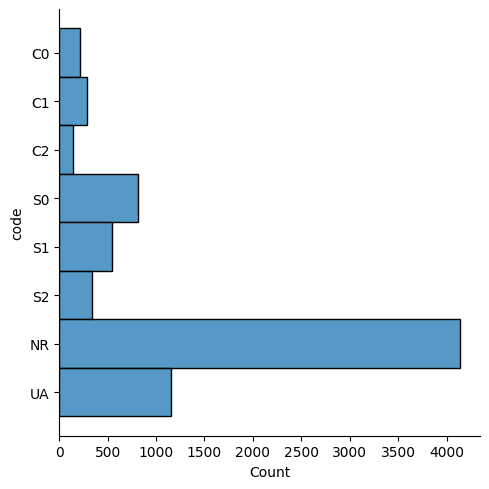

In [61]:
sns.displot(annots, y='code')
plt.show()

## Metric Summary

In [33]:
%%sql metrics <<
PIVOT (
    SELECT * FROM run_metrics
    WHERE query <> 'all'
)
ON metric
USING any_value(value)
GROUP BY team, version, query

Running query in 'DuckDBPyConnection'

In [44]:
metrics

team,version,query,P@1,P@10,P@5,PoolNDCG_10,R@1,R@10,R@5,agreement,avg_ndcg,diversity,nDCG_10,num_ret
jbnu-r01,complementary,PSRT_Recs_001C,0.0,0.0,0.0,None,0.0,0.0,0.0,None,None,0.7170000076293945,0.0,10.0
jbnu-r01,complementary,PSRT_Recs_003C,0.0,0.0,0.0,None,0.0,0.0,0.0,None,None,0.4666999876499176,0.0,10.0
jbnu-r01,complementary,PSRT_Recs_004C,0.0,0.0,0.0,None,0.0,0.0,0.0,None,None,1.0499999523162842,0.0,10.0
jbnu-r01,complementary,PSRT_Recs_016C,0.0,0.10000000149011612,0.20000000298023224,None,0.0,0.05559999868273735,0.05559999868273735,None,None,1.2742999792099,0.09589999914169312,10.0
jbnu-r01,complementary,PSRT_Recs_018C,0.0,0.10000000149011612,0.20000000298023224,None,0.0,0.05260000005364418,0.05260000005364418,None,None,1.437000036239624,0.04580000042915344,10.0
jbnu-r01,substitute,PSRT_Recs_002S,1.0,0.6000000238418579,0.800000011920929,None,0.03849999979138374,0.23080000281333923,0.15379999577999115,None,None,0.0,0.42750000953674316,10.0
jbnu-r01,related,PSRT_Recs_002R,None,None,None,0.7013000249862671,None,None,None,0.15150000154972076,0.5867999792098999,None,None,None
jbnu-r01,related,PSRT_Recs_009R,None,None,None,0.8769999742507935,None,None,None,-0.08169999718666077,0.6899999976158142,None,None,None
jbnu-r01,related,PSRT_Recs_021R,None,None,None,0.5903000235557556,None,None,None,0.7692000269889832,0.3068999946117401,None,None,None
jbnu-r01,related,PSRT_Recs_026R,None,None,None,0.507099986076355,None,None,None,0.39579999446868896,0.323199987411499,None,None,None


In [37]:
%%sql
SELECT DISTINCT metric FROM run_metrics

Running query in 'DuckDBPyConnection'

metric
R@1
P@1
R@5
num_ret
P@10
nDCG_10
diversity
R@10
avg_ndcg
agreement


In [73]:
%%sql ndcg <<
SELECT team, CASE WHEN version = 'related' THEN 'pool' ELSE version END AS Ranking, query, value AS NDCG
FROM run_metrics
WHERE query <> 'all'
AND metric IN ('PoolNDCG_10', 'nDCG_10')

Running query in 'DuckDBPyConnection'

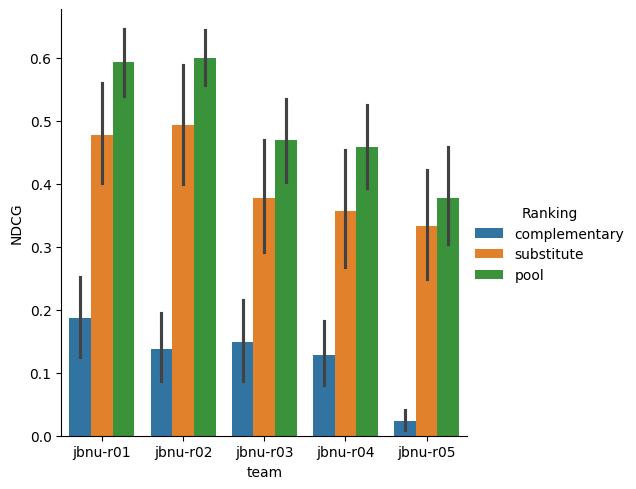

In [75]:
sns.catplot(ndcg.DataFrame(), x='team', y='NDCG', hue='Ranking', kind='bar')

In [65]:
%%sql aggr <<
SELECT team, version, query, value AS Kappa
FROM run_metrics
WHERE query <> 'all'
AND metric IN ('agreement')

Running query in 'DuckDBPyConnection'

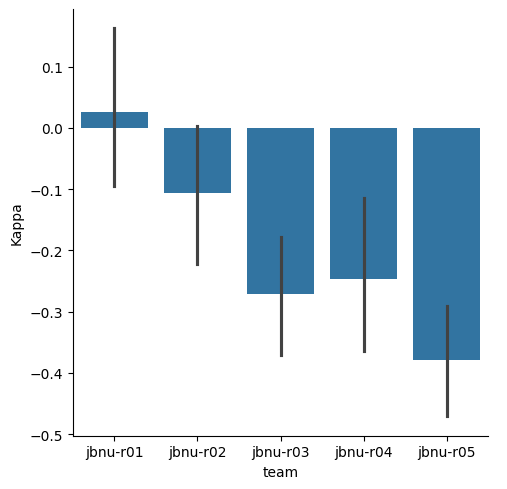

In [67]:
sns.catplot(aggr.DataFrame(), x='team', y='Kappa', kind='bar')